In [1]:
# Note: after computing the LRP, here we examine the most relevant features
# Also, we do a sort-of-selection of features (based on maximum values)

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
#for plotting
import geopandas as gpd

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.utils_plot import *

import yaml
conf = yaml.safe_load(open("config.yaml"))

In [2]:
# load data
# test samples
dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))
dg_train_Y_xtrm = xr.open_dataarray('tmp/data/dg_train_Y_xtrm0.95th.nc')

In [3]:
dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc'))
dg_test_Y_xtrm = xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc')

In [4]:
y_bool= dg_train_Y_xtrm

In [6]:
# Open LRP files
lrp_a1b0_train = np.load('tmp/LRP/old/a1b0_train_DNN_UNET4.npy')

In [ ]:
# Compare with the LRP_comp
lrp_comp_train = np.load('tmp/LRP/old/lrpcomp_test_DNN_UNET4.npy')

In [6]:
# coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# test-times
times = np.arange(np.datetime64('1979-01-01'), np.datetime64('2006-01-01'))
times = pd.to_datetime(times)

In [7]:
def getmap_rel(a, i_shape, y_bool, allmap =True):
    """Function to calculate the maximum relevances when extremes occur pr_xtrm==1
       Args: a: numpy array with the relevances
             i_shape: shape of the array
             y_bool: xarray.dataarry or array of the true extreme
             allmap: True, to calculate the maximum of relavances over the map, False for a pixel-wise calculation"""
    # process rel
    y_bool = np.array(y_bool)
    m = np.zeros(shape=(i_shape[0],i_shape[1], i_shape[2]))
    mmax = np.zeros(shape=(i_shape[0],i_shape[1], i_shape[2]))
    for ilon in range(0,len(lons_x)):
        for ilat in range(0,len(lats_y)):
            idx_s = y_bool[:,ilat, ilon] ==1
            idx_s = idx_s.flatten()
            # select the extreme dates and calculate the averages
            if (allmap == True):
                tmp = a[idx_s, :, :, :]
                tmp = tmp.max(axis=(1,2))
            else:
                tmp = a[idx_s, ilat, ilon, :]
                tmp[np.where(tmp < 0)] = 0.

            m[ilat, ilon,:] = tmp.mean(axis=0)
            mmax[ilat, ilon,:] = tmp.max(axis=0)
            
    return m, mmax
        
        

In [8]:
def getmap_localrel(a, i_shape, y_bool, lats_y, lons_y, times, icrop = 5):
    """Function to calculate the maximum relevances when extremes occur pr_xtrm==1
             over the closest pixels
             Args: a: numpy array with the relevances
             i_shape: shape of the array
             lats, lons: coordinates
             y_bool: xarray.dataarry or array of the true extreme
             icrop: select the number of pixels we want to calculate the relevances for a given point"""

    threshold_quant = np.quantile(a, 0.999)
    a_maxed = lrp_a1b0_train
    a_maxed[a_maxed>threshold_quant] = threshold_quant
    
    m_a1b0= xr.DataArray(a, dims=["time","lat", "lon", "variable"],
                  coords=dict(time = times, lat = lats_y, 
            lon = lons_x, variable= conf['varnames'] ))

    
    crop_lats = lats_y[icrop:len(lats_y)-icrop]
    crop_lons = lons_x[icrop:len(lons_x)-icrop]
        
    m = np.zeros(shape=(len(crop_lats),len(crop_lons), i_shape[2]))
    mmax = np.zeros(shape=(len(crop_lats),len(crop_lons), i_shape[2]))
    
    for ilon in range(0,len(crop_lons)):
        for ilat in range(0,len(crop_lats)):
            
            idx_s = y_bool.sel(lat=crop_lats[ilat], lon=crop_lons[ilon]) ==1
            idx_s = np.array(idx_s)
            idx_s = idx_s.flatten()
            
            m_sel = m_a1b0.sel(lat=slice(crop_lats[ilat]+icrop,crop_lats[ilat]-icrop),lon=slice(crop_lons[ilon]-icrop,crop_lons[ilon]+icrop))
            
            tmp = m_sel[idx_s, :, :, :]
            tmp = tmp.max(axis=(1,2))
           
            m[ilat, ilon,:] = tmp.mean(axis=0)
            mmax[ilat, ilon,:] = tmp.max(axis=0)
            
    return m, mmax

In [9]:
localrel_avg, localrel_max = getmap_localrel(lrp_a1b0_train, conf['i_shape'], y_bool, lats_y, lons_x, times, icrop=3)

In [11]:
crop_lats = lats_y[3:len(lats_y)-3]
crop_lons = lons_x[3:len(lons_x)-3]

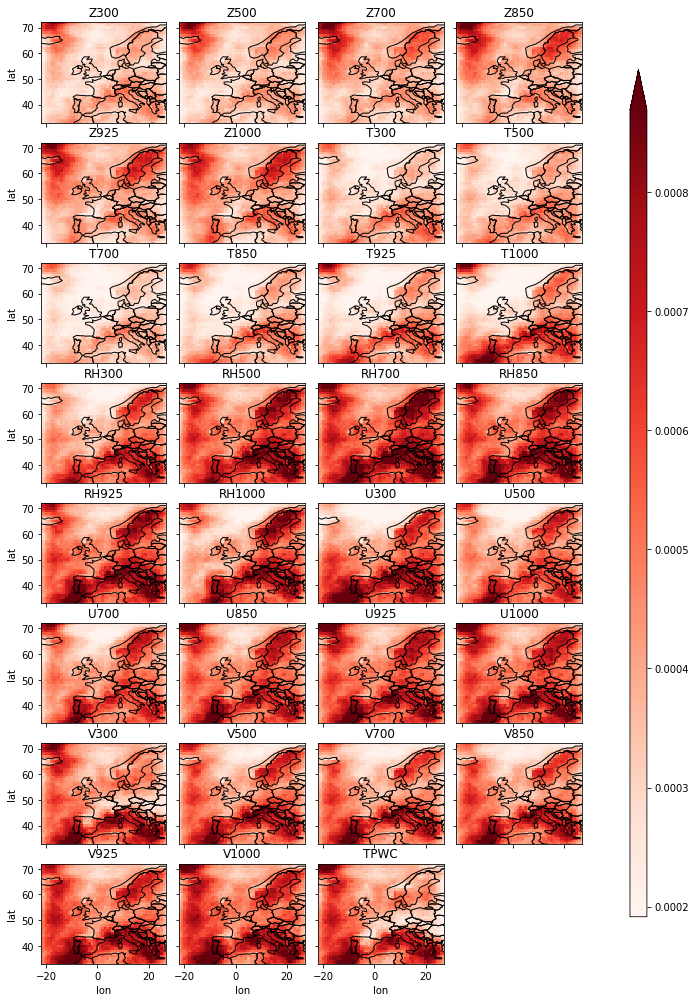

In [13]:
plot_xr_rel(localrel_avg, crop_lats, crop_lons, conf['varnames'], 'relevances_unet4_crop3')

In [ ]:
rel_varmeans = localrel_avg.mean(axis=(0,1))

In [ ]:
df_sortedvars = [conf['varnames'][i] for i in np.argsort(rel_varmeans)[::-1]]

In [ ]:
df_sortval = [rel_varmeans[i] for i in np.argsort(rel_varmeans)[::-1]]
data={'Variable' : df_sortedvars, 'Values' : df_sortval}
df = pd.DataFrame(data)
df.to_csv('tmp/df_sort_list_crop_train.csv', index=False)

In [ ]:
# Calculate relevances as average (not-cropping)

In [14]:
pixelrel_avg, pixelrel_max = getmap_rel(lrp_a1b0_train, conf['i_shape'], y_bool, False)

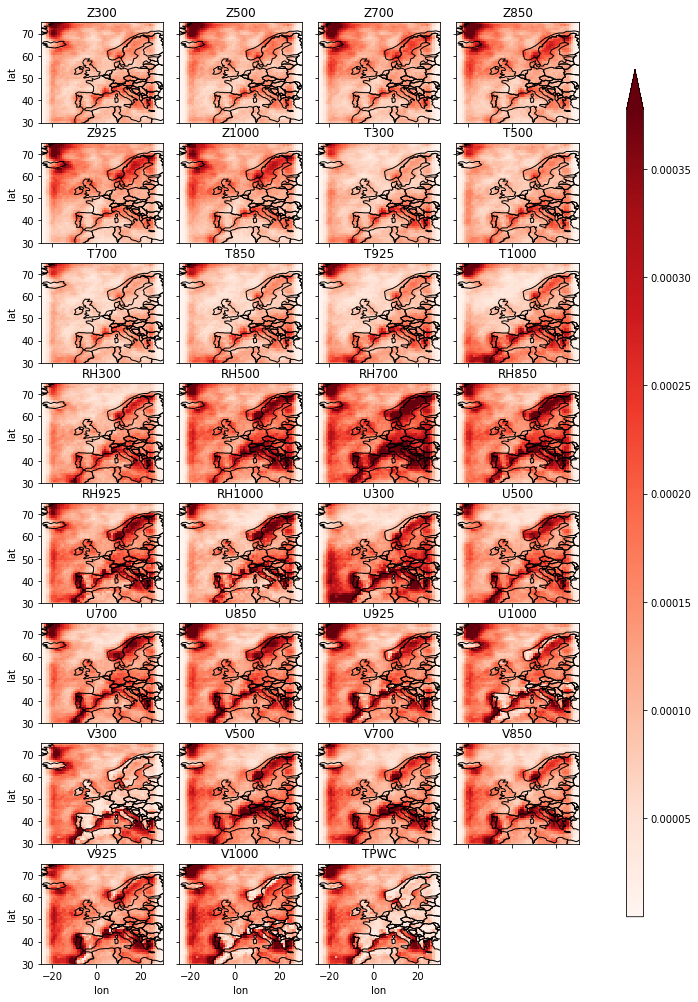

In [17]:
plot_xr_rel(pixelrel_avg, lats_y, lons_x, conf['varnames'], 'relevances_unet4_pixelwise')